In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score,
    accuracy_score, confusion_matrix
)
import matplotlib.pyplot as plt

In [2]:
# Parameters
training_start_date = pd.to_datetime("2018-01-01", utc=True)
split_date = pd.to_datetime("2023-12-31", utc=True)
test_end_date = pd.to_datetime("2024-12-31", utc=True)
k = 10  # top-k stocks

In [3]:
def load_hyperparameters(filepath="hyperparams.txt"):
    param_dict = {}
    with open(filepath, "r") as file:
        next(file)  # Skip the header line
        for line in file:
            parts = line.strip().split(",")
            if len(parts) != 3:
                continue
            ticker, n_estimators, max_depth = parts
            try:
                n_estimators = int(n_estimators)
                max_depth = None if max_depth == "None" else int(max_depth)
                param_dict.setdefault(ticker.upper(), []).append((n_estimators, max_depth))
            except ValueError:
                continue  # Skip malformed lines
    return param_dict


# Feature engineering
def calculate_rsi(series, window=14):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window).mean()
    avg_loss = loss.rolling(window).mean()
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

def calculate_ema(series, span):
    return series.ewm(span=span, adjust=False).mean()

def enrich_features(df):
    df['RSI'] = calculate_rsi(df['Close'])
    df['EMA12'] = calculate_ema(df['Close'], 12)
    df['EMA26'] = calculate_ema(df['Close'], 26)
    df['EMA20'] = calculate_ema(df['Close'], 20)
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Rolling_Avg_5'] = df['Close'].rolling(5).mean()
    df['Rolling_Avg_21'] = df['Close'].rolling(21).mean()
    df['Rolling_STD_20'] = df['Close'].rolling(20).std()
    df['Lag_1'] = df['Close'].shift(1)
    df['Lag_5'] = df['Close'].shift(5)
    df['Lag_10'] = df['Close'].shift(10)
    df['daily_return'] = df['Close'].pct_change()
    df['Rolling_Return_5'] = df['daily_return'].rolling(5).mean()
    df['Rolling_Volume_20'] = df['Volume'].rolling(20).mean()
    df['Price_Range'] = df['High'] - df['Low']
    df['Volatility_Ratio'] = df['Price_Range'] / df['Close']
    df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
    df['MA_Diff'] = df['EMA12'] - df['EMA26']
    df['Price_vs_RollingAvg'] = df['Close'] - df['Rolling_Avg_21']
    df['Close_t+1'] = df['Close'].shift(-1)
    df['Direction_t+1'] = np.sign(df['Close_t+1'] - df['Close'])
    return df

features = [
    'RSI', 'EMA12', 'EMA20', 'EMA26', 'MACD',
    'Rolling_Avg_5', 'Rolling_Avg_21', 'Rolling_STD_20',
    'Lag_1', 'Lag_5', 'Lag_10',
    'daily_return', 'Rolling_Return_5',
    'Rolling_Volume_20', 'Price_Range', 'Volatility_Ratio',
    'Momentum_5', 'MA_Diff', 'Price_vs_RollingAvg'
]

ticker_params = load_hyperparameters()
print("Loaded Hyperparameters to ticker_params")

Loaded Hyperparameters to ticker_params


In [4]:
ranking_data = []
all_results = []
direction_results = []
count = 0

for path in Path(r"/WAVE/projects/CSEN-140-Sp25/team_3/FinalDataFolder").glob("*.csv"):
    ticker = path.stem.upper()
    df = pd.read_csv(path, header=[0, 1], index_col=0)
    df.columns = [col[0] for col in df.columns]
    df.index = pd.to_datetime(df.index, errors='coerce', utc=True)
    df.sort_index(inplace=True)

    for col in ['Close', 'High', 'Low', 'Open', 'Volume']:
        df[col] = pd.to_numeric(df[col], errors='coerce')

    df = enrich_features(df)
    df.dropna(subset=features + ['Close_t+1', 'Direction_t+1'], inplace=True)
    if df.empty:
        print(f"{ticker} is empty")
        continue

    train_df = df[(df.index < split_date) & (df.index >= training_start_date)]
    test_df = df[(df.index >= split_date) & (df.index <= test_end_date)]

    # Normalize and reduce
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(train_df[features])
    X_test_scaled = scaler.transform(test_df[features])

    pca = PCA(n_components=0.99, svd_solver='full')
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)

    # Try all hyperparams for this ticker
    param_list = ticker_params.get(ticker, [(100, None)])  # Default
    best_reg, best_mae = None, float('inf')
    best_clf, best_acc = None, 0

    for n_est, max_d in param_list:
        try:
            reg = RandomForestRegressor(n_estimators=n_est, max_depth=max_d, random_state=42)
            reg.fit(X_train_pca, train_df['Close_t+1'])
            pred = reg.predict(X_test_pca)
            cur_mae = mean_absolute_error(test_df['Close_t+1'], pred)
            if cur_mae < best_mae:
                best_mae = cur_mae
                best_reg = reg

            clf = RandomForestClassifier(n_estimators=n_est, max_depth=max_d, random_state=42)
            clf.fit(X_train_pca, (train_df['Direction_t+1'] > 0).astype(int))
            cls_pred = clf.predict(X_test_pca)
            acc = accuracy_score((test_df['Direction_t+1'] > 0).astype(int), cls_pred)
            if acc > best_acc:
                best_acc = acc
                best_clf = clf
        except Exception as e:
            continue

    if best_reg is None or best_clf is None:
        continue

    y_pred = best_reg.predict(X_test_pca)
    y_cls = best_clf.predict(X_test_pca)

    test_df = test_df.iloc[:len(y_pred)].copy()
    test_df['Predicted'] = y_pred
    test_df['Actual'] = test_df['Close_t+1']
    test_df['Predicted_Up'] = y_cls
    test_df['Actual_Up'] = (test_df['Direction_t+1'] > 0).astype(int)
    test_df['Ticker'] = ticker
    test_df.dropna(subset=['Actual'], inplace=True)

    all_results.extend(test_df[['Ticker', 'Predicted', 'Actual']].assign(Date=test_df.index).to_dict('records'))
    direction_results.extend(test_df[['Predicted_Up', 'Actual_Up']].to_dict('records'))

    # Ranking logic
    first_row = test_df.iloc[0]
    current_price = first_row['Close']
    predicted_price = first_row['Predicted']
    actual_price = first_row['Actual']
    expected_return = predicted_price - current_price
    actual_return = actual_price - current_price
    performance_score = expected_return / current_price
    actual_return_pct = (actual_return / current_price) * 100
    sharpe_like = expected_return / (abs(expected_return - actual_return) + 1e-6)

    ranking_data.append({
        'Ticker': ticker,
        'Current Price': current_price,
        'Predicted t+1': predicted_price,
        'Expected Return': expected_return,
        'Performance per Price': performance_score,
        'Actual Return ($)': actual_return,
        'Actual Return (%)': actual_return_pct,
        'Sharpe Ratio': sharpe_like
    })

    count += 1
    if count % 50 == 0:
        print(f"Processed {count} stocks")

Processed 50 stocks
Processed 100 stocks
Processed 150 stocks
Processed 200 stocks
Processed 250 stocks
Processed 300 stocks
Processed 350 stocks
Processed 400 stocks
Processed 450 stocks


In [5]:
# === Evaluation === #
ranking_df = pd.DataFrame(ranking_data).dropna()
results_df = pd.DataFrame(all_results).drop_duplicates(subset=['Ticker', 'Date'])
results_df = results_df.groupby('Ticker').apply(lambda g: g.iloc[1:]).reset_index(drop=True)
direction_df = pd.DataFrame(direction_results).dropna()

# Metrics
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
mse = mean_squared_error(results_df['Actual'], results_df['Predicted'])
r2 = r2_score(results_df['Actual'], results_df['Predicted'])
mape = np.mean(np.abs((results_df['Actual'] - results_df['Predicted']) / results_df['Actual'])) * 100
rmse = np.sqrt(mse)

print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE Score: {rmse:.4f}")

MAE: 20.9983
MSE: 9134.7648
R² Score: 0.9574
MAPE: 7.0634
RMSE Score: 95.5760


/local/scratch/119670/ipykernel_2784828/4022502712.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results_df = results_df.groupby('Ticker').apply(lambda g: g.iloc[1:]).reset_index(drop=True)


In [6]:
# Direction Classification
direction_accuracy = accuracy_score(direction_df['Actual_Up'], direction_df['Predicted_Up'])
print(f"Direction Classification Accuracy: {direction_accuracy:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(direction_df['Actual_Up'], direction_df['Predicted_Up']))

Direction Classification Accuracy: 0.5118
Confusion Matrix:
[[28452 30915]
 [29497 34886]]


In [7]:
# Top-K Direction Accuracy
top_k_value = ranking_df.sort_values(by='Performance per Price', ascending=False).head(k)
top_k_pred = results_df[results_df['Ticker'].isin(top_k_value['Ticker'])]
top_k_direction_accuracy = accuracy_score(
    (top_k_pred['Actual'].diff() > 0).astype(int),
    (top_k_pred['Predicted'].diff() > 0).astype(int)
)
print(f"Top-K Direction Accuracy: {top_k_direction_accuracy:.4f}")

Top-K Direction Accuracy: 0.5193


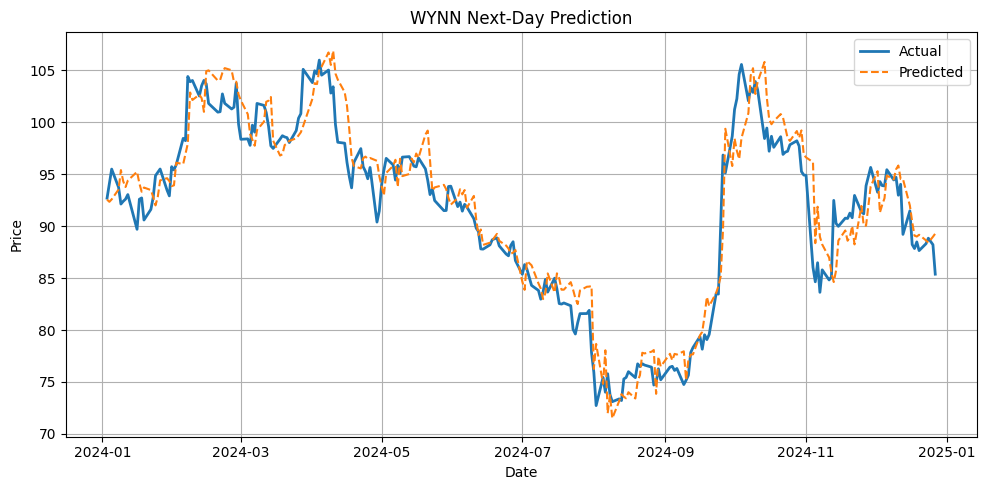

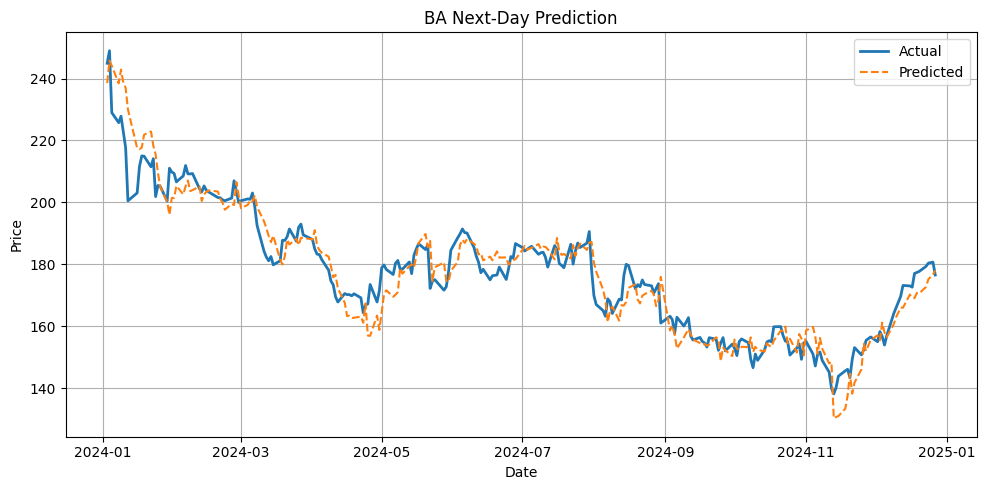

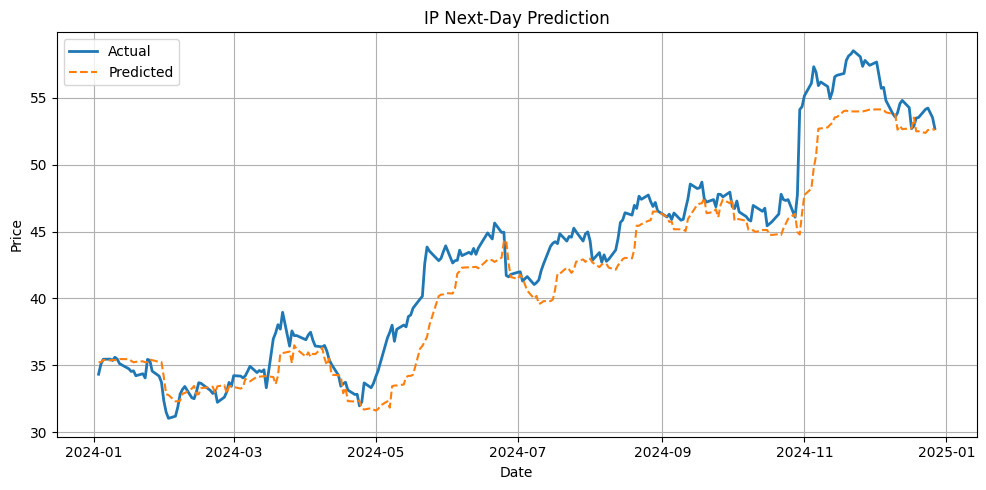

In [15]:
# Plots
for ticker in ['WYNN', 'BA', 'IP']:
    stock_df = results_df[results_df['Ticker'] == ticker]
    if stock_df.empty:
        continue
    plt.figure(figsize=(10, 5))
    plt.plot(stock_df['Date'], stock_df['Actual'], label='Actual', linewidth=2)
    plt.plot(stock_df['Date'], stock_df['Predicted'], label='Predicted', linestyle='--')
    plt.title(f"{ticker} Next-Day Prediction")
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()